# **01 - Exploratory Data Analysis**

In [21]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

### Available data 

| Attribute                        | Description                                                                 | Domain                                         |
|----------------------------------|-----------------------------------------------------------------------------|-----------------------------------------------|
| grid_id                          | Identifier of a cell in Menorca's map (column and row number)               | String                                        |
| cell_area_km2                          | Surface area of the cell, in square kilometers             | Float                                        |
| dominant_land_cover_name          | Dominant type of land in the cell                                           | String                                        |
| cost_adaptation_atelerix          | Cost of making some adaptations in the cell for the atelerix                | Float                                         |
| cost_adaptation_martes            | Cost of making some adaptations in the cell for the martes martes           | Float                                         |
| cost_adaptation_eliomys           | Cost of making some adaptations in the cell for the eliomys quercinus       | Float                                         |
| cost_adaptation_oryctolagus       | Cost of making some adaptations in the cell for the oryctolagus cuniculus  | Float                                         |
| cost_corridor                     | Cost of preparing a single corridor in the cell                              | Float                                         |
| suitability_atelerix              | **(New)** Biological habitat quality score for Atelerix algirus (0.0 to 3.0)    | Float                                         |
| suitability_martes                | **(New)** Biological habitat quality score for Martes martes (0.0 to 3.0)       | Float                                         |
| suitability_eliomys               | **(New)** Biological habitat quality score for Eliomys quercinus (0.0 to 3.0)   | Float                                         |
| suitability_oryctolagus           | **(New)** Biological habitat quality score for Oryctolagus cuniculus (0.0 to 3.0) | Float                                       |
| has_atelerix_algirus              | Whether or not the cell has a living colony of atelerix                     | Boolean                                       |
| has_martes_martes                 | Whether or not the cell has a living colony of martes martes                | Boolean                                       |
| has_eliomys_quercinus             | Whether or not the cell has a living colony of eliomys quercinus            | Boolean                                       |
| has_oryctolagus_cuniculus         | Whether or not the cell has a living colony of european rabbit              | Boolean                                       |
| geometry                          | The polygon that describes the cell (Only present in the .geojson file)    | Geometry                                      |

> **Note:** All cost values are considered in **thousands of euros**. For example, a value of 4.5 in the dataset is treated as €4,500.  

### 1. Load Data

In [22]:
df_geojson = gpd.read_file("../2_data/processed/final_dataset.geojson") # Load GeoJSON data

### 2. Analysis of Adaptation Costs

To assess the economic feasibility of habitat expansion, we analyzed the distribution of adaptation costs for each species across the island. All cost values are considered in **thousands of euros**. 
The following histograms display the frequency of costs (€ per unit area) required to modify a cell for a specific species.

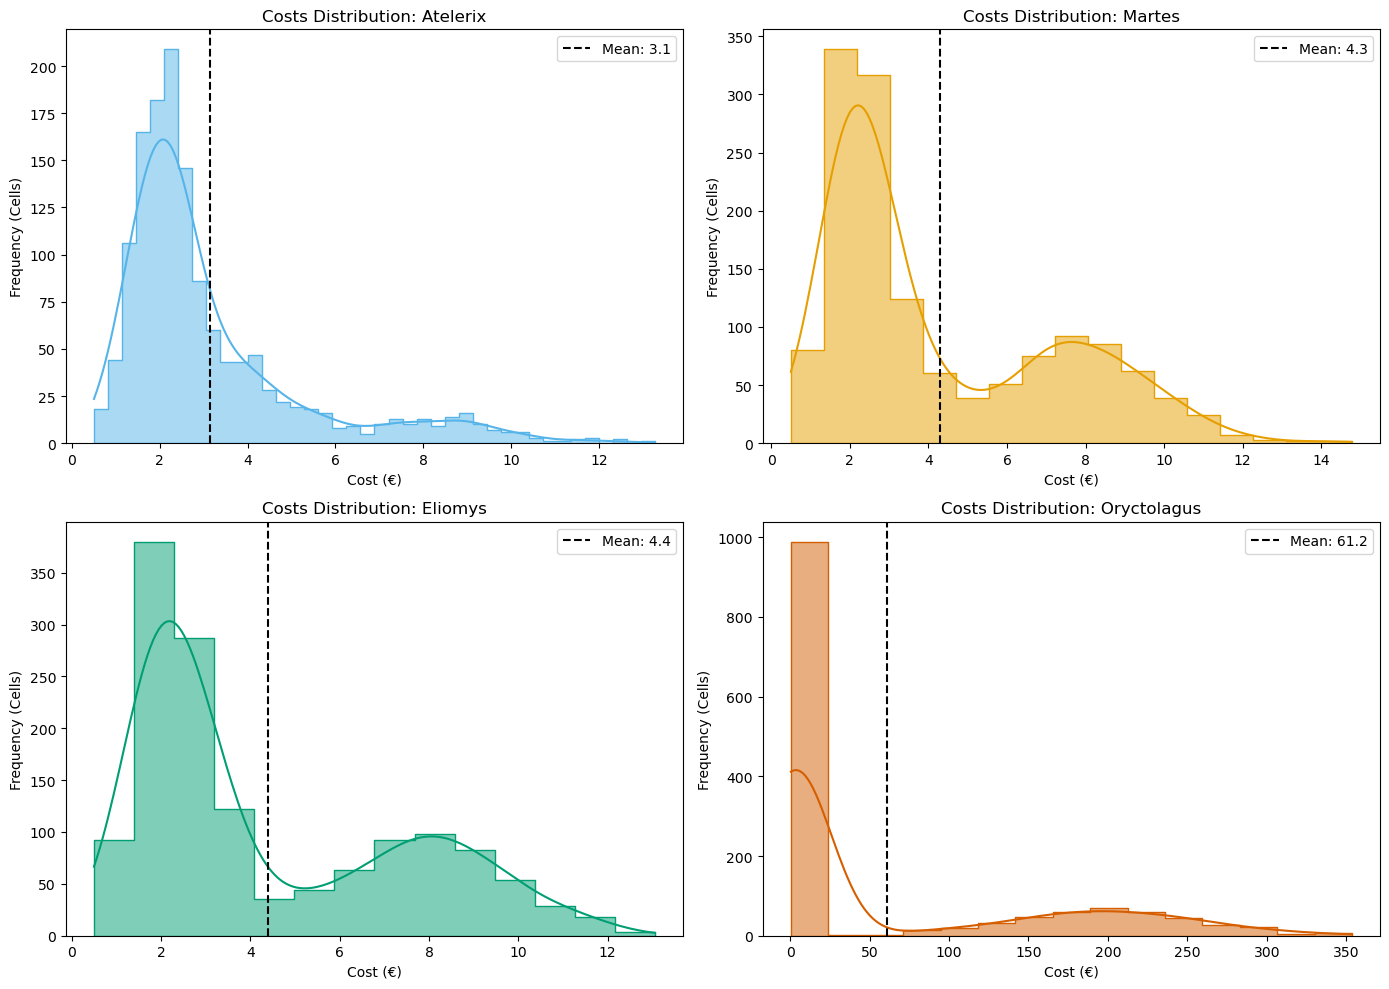

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

cost_cols = [
    'cost_adaptation_atelerix', 
    'cost_adaptation_martes', 
    'cost_adaptation_eliomys', 
    'cost_adaptation_oryctolagus'
]

colors = ['#56B4E9', '#E69F00', '#009E73', '#D55E00']

for i, col in enumerate(cost_cols):
    species_name = col.replace('cost_adaptation_', '').capitalize()
    sns.histplot(df_geojson[col], kde=True, ax=axes[i], color=colors[i], element="step")
    
    axes[i].set_title(f"Costs Distribution: {species_name}")
    axes[i].set_xlabel("Cost (€)")
    axes[i].set_ylabel("Frequency (Cells)")
    
    mean_val = df_geojson[col].mean()
    axes[i].axvline(mean_val, color='k', linestyle='--', label=f'Mean: {mean_val:.1f}')
    axes[i].legend()

plt.tight_layout()
plt.savefig("../5_results/EDA/costs_distribution_per_specie.png", dpi=300)
plt.show()

**Key Insights:**

1.  **Cost Disparity:** While the average adaptation cost for *Atelerix*, *Eliomys*, and *Martes* ranges between **3€ and 5€**, the average cost for *Oryctolagus* is approximately **60€**, with peaks exceeding 300€.
2.  **Variance and Location Sensitivity:**
    * **Low Variance (*Atelerix, Martes, Eliomys*):** The costs for these species are relatively homogeneous and concentrated around the mean (narrow distribution). This implies that, economically, most cells are equally viable candidates for expansion.
    * **High Variance (*Oryctolagus*):** Its cost distribution is highly spread out (high standard deviation). This indicates that location selection is critical for this species; choosing the wrong cell could drain the budget disproportionately compared to an optimal one.
3.  **Budgetary Implications:** The high baseline cost for *Oryctolagus* suggests that any strategy involving its habitat expansion will be an important driver of budget consumption. The optimization model will face a significant trade-off: expanding one unit of *Oryctolagus* habitat could be equivalent to expanding ~15-20 units of habitat for other species.

### 3. Comprehensive Spatial Analysis: Species Co-occurrence

To quantify the overlap and segregation of species at the cell level, we generated a **Species Co-occurrence Matrix**. Each entry in the matrix represents the number of cells where a pair of species co-exist.

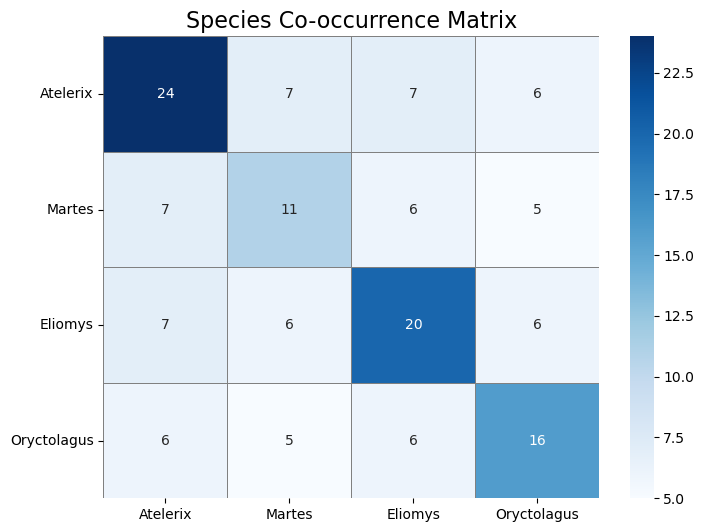

Cells with three species: 1
Cells with all four species: 5
Cell with three species: ['Atelerix', 'Eliomys', 'Oryctolagus']


In [24]:
species_config = [
    ('has_atelerix_algirus', '#1f77b4', 'Atelerix'),
    ('has_martes_martes', '#ff7f0e', 'Martes'),
    ('has_eliomys_quercinus', '#2ca02c', 'Eliomys'),
    ('has_oryctolagus_cuniculus', '#d62728', 'Oryctolagus')
]

species_cols = [col for col, _, _ in species_config]
species_names = [name for _, _, name in species_config]

co_occurrence = pd.DataFrame(index=species_names, columns=species_names, dtype=int)

for i, (col1, _, name1) in enumerate(species_config):
    for j, (col2, _, name2) in enumerate(species_config):
        co_occurrence.loc[name1, name2] = ((df_geojson[col1]) & (df_geojson[col2])).sum()

plt.figure(figsize=(8,6))
sns.heatmap(co_occurrence, annot=True, cmap="Blues", linewidths=0.5, linecolor='gray')
plt.title("Species Co-occurrence Matrix", fontsize=16)
plt.yticks(rotation=0)
plt.savefig("../5_results/EDA/co_occurrence_matrix.png", dpi=300)
plt.show()

species_cols = [col for col, _, _ in species_config]
df_geojson['num_species'] = df_geojson[species_cols].sum(axis=1)

three_species_cells = df_geojson[df_geojson['num_species'] == 3]
four_species_cells = df_geojson[df_geojson['num_species'] == 4]

print(f"Cells with three species: {len(three_species_cells)}")
print(f"Cells with all four species: {len(four_species_cells)}")

for idx, row in three_species_cells.iterrows():
    present_species = [name for col, _, name in species_config if row[col]]
    print(f"Cell with three species: {present_species}")


**Key Insights:**
1. **High Co-occurrence:** Some cells host multiple species. In our dataset:
   - 1 cell contains three species (*Atelerix*, *Eliomys*, *Oryctolagus*).
   - 5 cells contain all four species.
2. **Species Pair Overlaps:** The matrix highlights how often species pairs share the same cell. For example:
   - *Atelerix* co-occurs with *Martes* in 7 cells.
   - *Eliomys* co-occurs with *Oryctolagus* in 6 cells.
3. **Segregation Patterns:** While most species co-occur occasionally, certain pairs are less frequent together (e.g., *Martes* and *Oryctolagus* in only 5 cells).

This matrix-based approach allows a clear, quantitative understanding of species overlap without requiring geometric plotting.

### 4. Correlation Analysis: Habitat Suitability vs. Adaptation Costs

To explore the relationships between habitat quality, adaptation costs, and human disturbance, we computed the correlation matrix across all species-specific suitability and adaptation cost variables, including `human_disturbance` and `cost_corridor`.

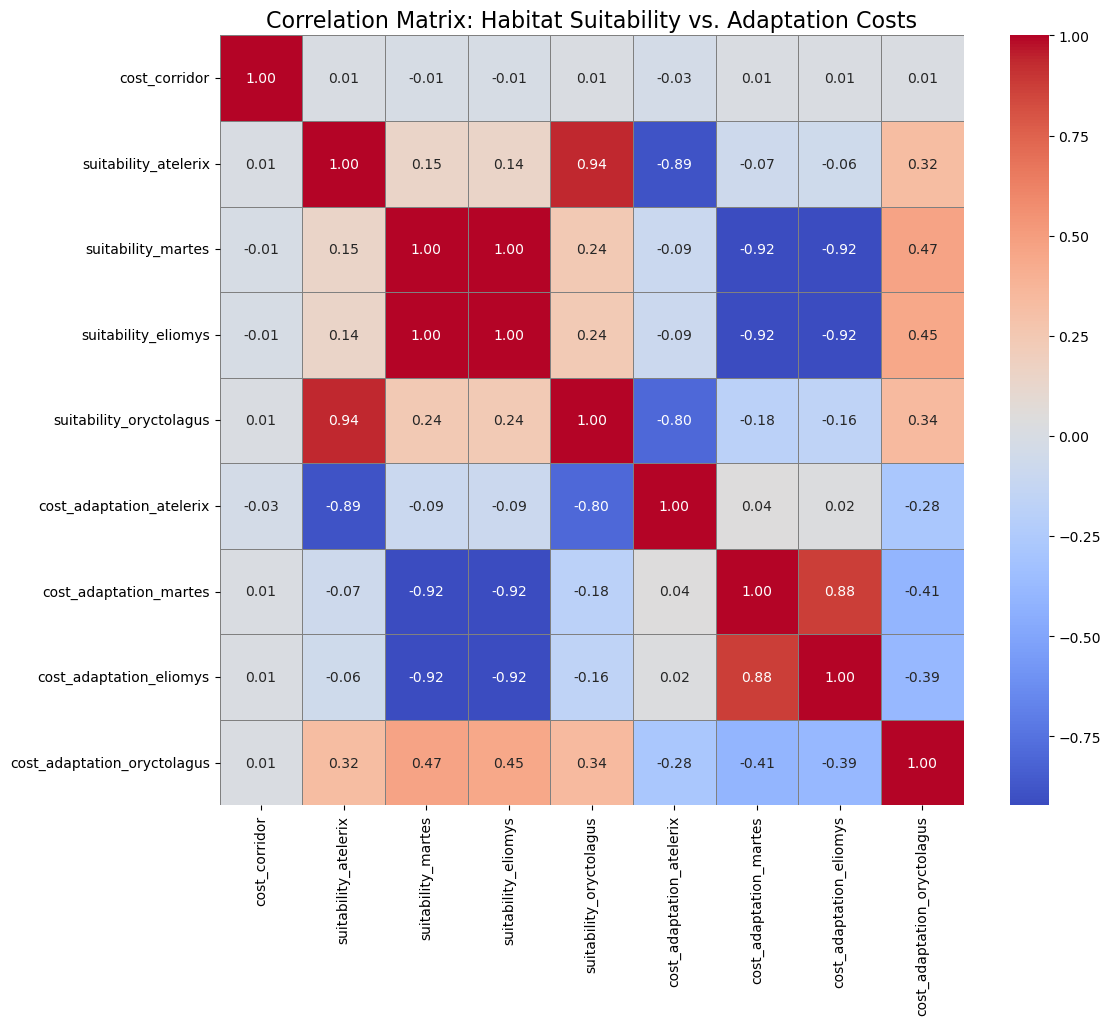

In [25]:
suitability_cols = [
    'suitability_atelerix', 
    'suitability_martes', 
    'suitability_eliomys', 
    'suitability_oryctolagus'
]

cost_cols = [
    'cost_adaptation_atelerix', 
    'cost_adaptation_martes', 
    'cost_adaptation_eliomys', 
    'cost_adaptation_oryctolagus'
]

cols_corr = ['cost_corridor'] + suitability_cols + cost_cols

corr = df_geojson[cols_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, linecolor='gray')
plt.title("Correlation Matrix: Habitat Suitability vs. Adaptation Costs", fontsize=16)
plt.savefig("../5_results/EDA/correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

**Key Insights:**
1. **Suitability vs. Adaptation Costs:** Strong negative correlations between suitability and adaptation costs for *Atelerix* (-0.89) highlight that improving highly suitable habitats is generally cost-effective.  
   For *Martes* and *Eliomys*, high suitability often comes with high adaptation costs (-0.92 each).  
   **Note:** *Oryctolagus* has higher average adaptation costs overall, despite moderate correlations with suitability, reflecting more expensive habitat improvements.
2. **Inter-species Patterns:** Suitability of *Atelerix* and *Oryctolagus* are highly positively correlated (0.94), suggesting overlapping habitat preferences, while *Martes* and *Eliomys* also show perfect correlation (1.00), reflecting similar ecological niches.
3. **Cost Relationships:** Adaptation costs for *Martes* and *Eliomys* are strongly correlated (0.88), indicating that efforts to improve habitat for one species often require similar investments for the other.

### 5. Land Cover Distribution

In [26]:
land_cover_counts = df_geojson['dominant_land_cover_name'].value_counts()
land_cover_table = land_cover_counts.reset_index()
land_cover_table.columns = ['Land Cover Type', 'Number of Cells']

land_cover_table['Percentage'] = (land_cover_table['Number of Cells'] / len(df_geojson) * 100).round(2)

total_row = pd.DataFrame({
    'Land Cover Type': ['Total'],
    'Number of Cells': [land_cover_table['Number of Cells'].sum()],
    'Percentage': [land_cover_table['Percentage'].sum()]
})
land_cover_table = pd.concat([land_cover_table, total_row], ignore_index=True)
print(land_cover_table.to_string(index=False))

                                                                      Land Cover Type  Number of Cells  Percentage
                                                            Sclerophyllous Vegetation              272       19.41
                                                            Non-irrigated Arable Land              201       14.35
Land Principally Occupied by Agriculture with Significant Areas of Natural Vegetation              159       11.35
                                                                             Pastures              135        9.64
                                                                 Broad-leaved Forests              125        8.92
                                                          Transitional Woodland-Shrub              113        8.07
                                                                   Coniferous Forests               98        7.00
                                                                        Mixed Fo

**Key Insights:**
1. **Dominant Natural Habitats:** Sclerophyllous Vegetation (272 cells) and Non-irrigated Arable Land (201 cells) are the most common land cover types on the island.
2. **Agricultural Influence:** Combined, agricultural areas (arable lands, pastures, and complex cultivation patterns) account for a substantial portion of the landscape.
3. **Forest Distribution:** Broad-leaved, Mixed, Coniferous, and Transitional Woodland-Shrub forests cover significant areas but are less prevalent than open vegetation and agricultural lands.
4. **Urban Areas:** Discontinuous Urban Fabric (62 cells) and Continuous Urban Fabric (13 cells) indicate moderate human presence in some areas, especially around settlements.
5. **Rare Habitats:** Wetlands, coastal lagoons, and intertidal flats are extremely limited, highlighting sensitive ecological niches.

### 6. Suitability Matrix: Species vs. Land Cover Type

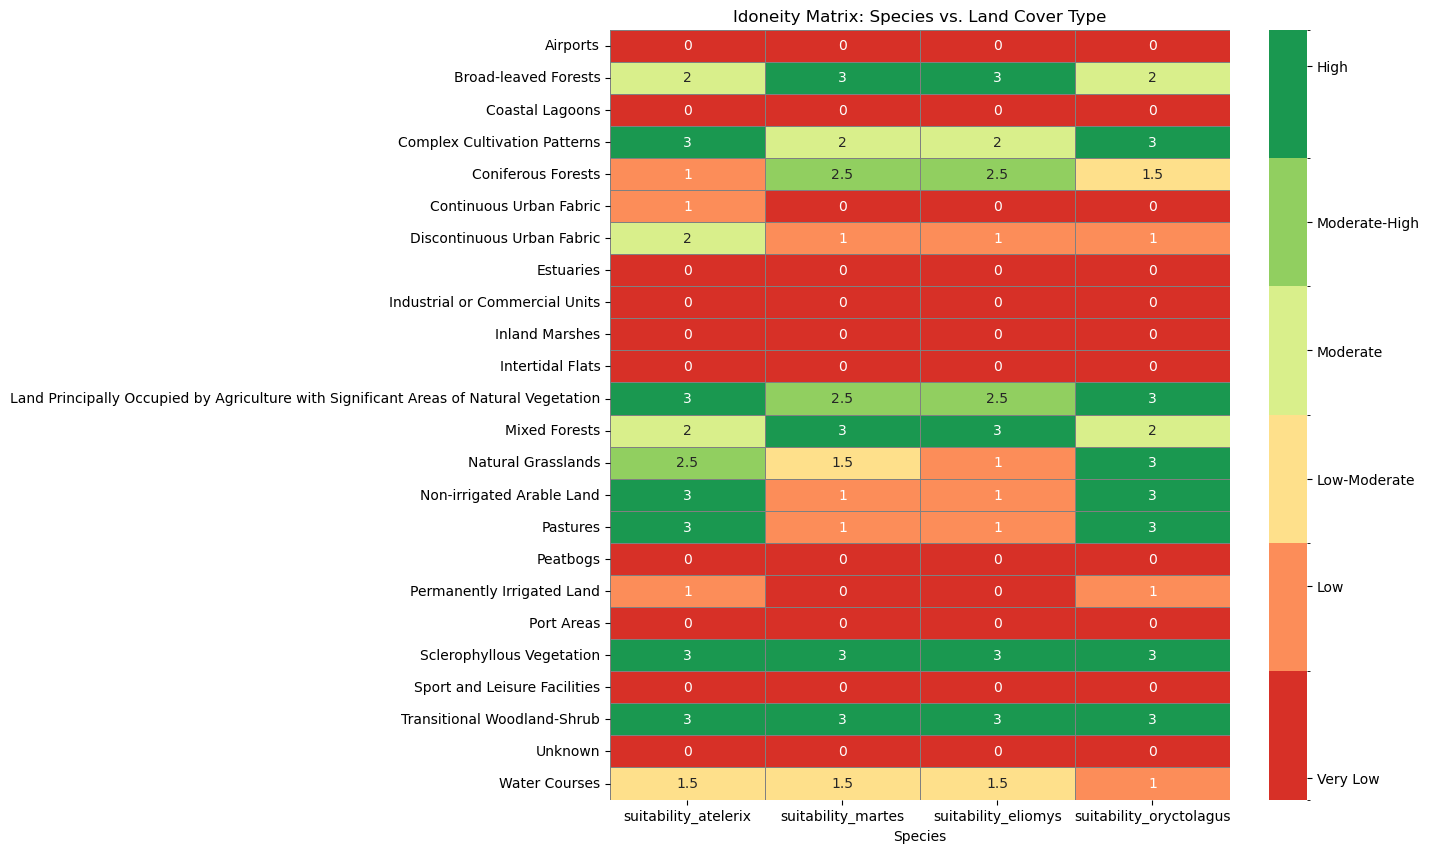

In [27]:
suitability_cols = ['suitability_atelerix', 'suitability_martes', 
                    'suitability_eliomys', 'suitability_oryctolagus']
rules_matrix = df_geojson.groupby('dominant_land_cover_name')[suitability_cols].first()

categories = ["Very Low", "Low", "Low-Moderate", "Moderate", "Moderate-High", "High"]
values = [0, 1, 1.5, 2, 2.5, 3]
colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850']

cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=[-0.1,0.5,1.25,1.75,2.25,2.75,3.1], ncolors=len(colors))

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    rules_matrix,
    annot=True,
    cmap=cmap,
    norm=norm,
    linewidths=0.5,
    linecolor='gray',
    cbar=True
)

cbar = ax.collections[0].colorbar
cbar.set_ticks(values)
cbar.set_ticklabels(categories)  

plt.title("Idoneity Matrix: Species vs. Land Cover Type")
plt.ylabel("")
plt.xlabel("Species")
plt.savefig("../5_results/EDA/idoneity_matrix_per_specie_per_land_type.png", dpi=300, bbox_inches='tight')
plt.show()

**Key Insights:**
1. **Consistently High Suitability in Natural Mediterranean Habitats:** Sclerophyllous Vegetation and Transitional Woodland–Shrub show uniformly high suitability (value = 3) for all four species, confirming these habitats as core ecological environments.
2. **Predator–Prey Divergence in Forested Ecosystems:** *Martes* and *Eliomys* maintain high suitability in Broad-leaved and Mixed Forests, whereas *Atelerix* and *Oryctolagus* drop to moderate levels (value = 2), indicating differentiated niche use within forest habitats.
3. **Agricultural Mosaics Support Generalist Species:** Land Principally Occupied by Agriculture and Complex Cultivation Patterns yield moderate to high suitability for all species (2–3), suggesting that mosaic landscapes facilitate multispecies coexistence.
4. **Urban Areas Create Sharp Suitability Contrasts:**  Discontinuous Urban Fabric remains moderately suitable for *Atelerix* (value = 2) but severely reduces suitability for the other species (value = 1 or 0), while Continuous Urban Fabric is almost uniformly unsuitable.
5. **Wetlands and Anthropogenic Infrastructures Are Generally Unsuitable:** Water courses, irrigated lands, industrial areas, and similar categories show very low suitability across species (0–1), marking them as ecological barriers within the landscape.